# AI-Guided Drug Optimization: Adverse Event Detection and Medication Reassignment via Patient Similarity Modeling (for Oncology Patients)

### 1. Loading required libararies

In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.metrics import classification_report
from datasets import Dataset
import umap
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, pipeline
from torch.optim import AdamW
from tqdm import tqdm


### 2. Load MIMIC-III data

In [5]:
prescriptions = pd.read_csv("PRESCRIPTIONS.csv")
diagnoses = pd.read_csv("DIAGNOSES_ICD.csv")
icd_lookup = pd.read_csv("D_ICD_DIAGNOSES.csv")
patients = pd.read_csv("PATIENTS.csv")
admissions = pd.read_csv("ADMISSIONS.csv")
labs = pd.read_csv("LABEVENTS.csv")
notes = pd.read_csv("NOTEEVENTS.csv")

/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_4600/2014850454.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  prescriptions = pd.read_csv("PRESCRIPTIONS.csv")
/var/folders/8s/rjjqh8m12hggt98w3x81db0m0000gn/T/ipykernel_4600/2014850454.py:7: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  notes = pd.read_csv("NOTEEVENTS.csv")


## Data Processing
### 3. Filter Oncology Patients and calculate Age for Features.

In [7]:
icd_lookup['ICD_CATEGORY'] = icd_lookup['ICD9_CODE'].str[:3]
oncology_icd_codes = icd_lookup[icd_lookup['ICD_CATEGORY'].astype(str).between('140', '239')]['ICD9_CODE']
oncology_patients = diagnoses[diagnoses['ICD9_CODE'].isin(oncology_icd_codes)]
oncology_patient_ids = oncology_patients['SUBJECT_ID'].unique()

#age calcualtion
patients['DOB'] = pd.to_datetime(patients['DOB'], errors='coerce')
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'], errors='coerce')
demo = pd.merge(admissions[['SUBJECT_ID', 'ADMITTIME']], patients[['SUBJECT_ID', 'DOB', 'GENDER']], on='SUBJECT_ID').dropna()

def calculate_age(row):
    return row['ADMITTIME'].year - row['DOB'].year - ((row['ADMITTIME'].month, row['ADMITTIME'].day) < (row['DOB'].month, row['DOB'].day))
demo['AGE'] = demo.apply(calculate_age, axis=1)
demo = demo[(demo['AGE'] >= 0) & (demo['AGE'] <= 120)]
demo['GENDER'] = demo['GENDER'].map({'M': 0, 'F': 1})
demo = demo[['SUBJECT_ID', 'AGE', 'GENDER']].drop_duplicates()

### 4. Feature creation, transposing the lab test item id into column values & Clustering

In [9]:
labs_filtered = labs[labs['SUBJECT_ID'].isin(oncology_patient_ids)]
lab_features = labs_filtered.pivot_table(index='SUBJECT_ID', columns='ITEMID', values='VALUENUM', aggfunc='mean').fillna(0)

features_raw = lab_features.reset_index().merge(demo, on='SUBJECT_ID')
features_raw.columns = features_raw.columns.astype(str)
features_raw.set_index('SUBJECT_ID', inplace=True)

#Scale features
X_scaled = StandardScaler().fit_transform(features_raw)

#Dimensionality reduction (better)
umap_model = umap.UMAP(n_components=12, n_neighbors=15, min_dist=0.3, random_state=42)
X_umap = umap_model.fit_transform(X_scaled)


#HDBSCAN clustering
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=10)
labels = clusterer.fit_predict(X_umap)

#Evaluate
from sklearn.metrics import silhouette_score
score = silhouette_score(X_umap[labels != -1], labels[labels != -1])  # exclude noise
print(f'HDBSCAN Silhouette Score (excluding noise): {score:.4f}')

#Save clusters
features = features_raw.copy()
features['CLUSTER_HDBSCAN'] = labels

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


HDBSCAN Silhouette Score (excluding noise): 0.5316


In [10]:
features

,50801,50802,50803,50804,50805,50806,50808,50809,50810,50811,...,51516,51517,51519,51521,51526,51529,51533,AGE,GENDER,CLUSTER_HDBSCAN
SUBJECT_ID,,,,,,,,,,,,,,,,,,,,,
11,0.0,2.000000,0.0,25.000000,0.0,105.000000,1.090000,94.000000,35.000000,11.800000,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,50,1,108
12,0.0,-4.700000,10.0,22.033333,0.0,113.000000,1.096000,150.200000,30.100000,10.000000,...,6.000000,0.0,0.0,0.0,0.0,0.0,0.0,72,0,-1
21,558.0,-3.812500,0.0,23.062500,0.0,100.000000,1.219231,104.666667,29.250000,9.725000,...,30.000000,0.0,0.0,0.0,0.0,0.0,0.0,87,0,-1
23,0.0,-1.133333,0.0,24.600000,0.0,102.000000,1.131429,116.666667,32.142857,10.685714,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,71,0,-1
23,0.0,-1.133333,0.0,24.600000,0.0,102.000000,1.131429,116.666667,32.142857,10.685714,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,75,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99865,0.0,-5.470588,24.0,22.000000,0.0,109.714286,0.943333,109.142857,28.500000,9.500000,...,72.000000,0.0,0.0,0.0,0.0,0.0,0.0,77,1,-1
99872,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,23.000000,7.800000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,54,1,-1
99899,392.0,-4.733333,0.0,21.733333,0.0,91.000000,1.190000,159.000000,17.666667,5.833333,...,35.666667,0.0,0.0,0.0,0.0,0.0,0.0,86,0,-1


### 5.Plotting Cluster

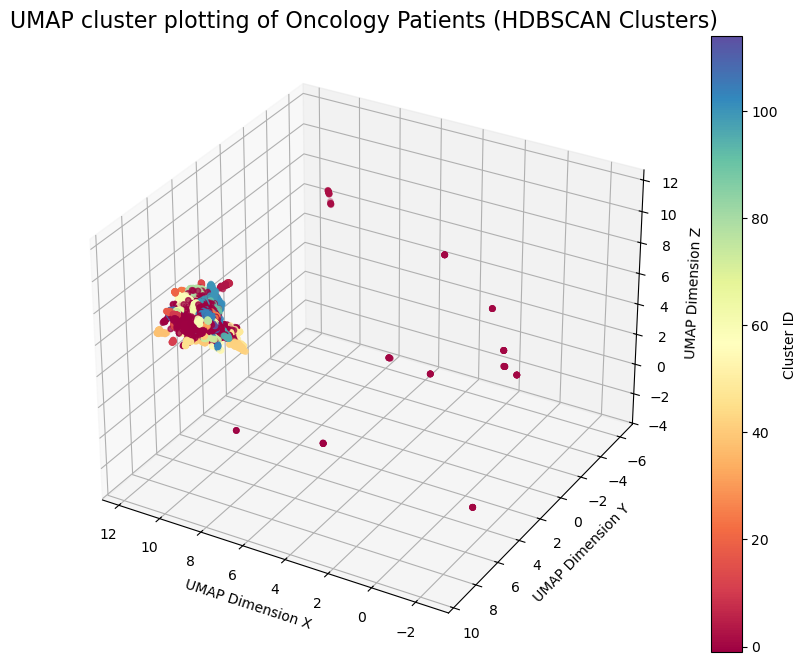

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#Create 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot points
scatter = ax.scatter(
    X_umap[:, 0],    # UMAP dimension 1
    X_umap[:, 1],    # UMAP dimension 2
    X_umap[:, 2],    # UMAP dimension 3
    c=labels,        # color by cluster label
    cmap='Spectral', # color map
    s=15             # point size
)
fig.colorbar(scatter, ax=ax, label='Cluster ID')

#Labels
ax.set_title('UMAP cluster plotting of Oncology Patients (HDBSCAN Clusters)', fontsize=16)
ax.set_xlabel('UMAP Dimension X')
ax.set_ylabel('UMAP Dimension Y')
ax.set_zlabel('UMAP Dimension Z')
ax.view_init(elev=30, azim=120)
plt.show()


### 6. Using ClinicalBERT to find the Adverse Event Patients

In [14]:
oncology_notes = notes[
    (notes['SUBJECT_ID'].isin(oncology_patient_ids)) &
    (notes['CATEGORY'] == 'Discharge summary') &
    (notes['TEXT'].notna())
]

sample_notes = oncology_notes.groupby('SUBJECT_ID').first().reset_index().head(1000)
sample_notes['LABEL'] = sample_notes['TEXT'].apply(
    lambda x: 1 if any(word in x.lower() for word in ['adverse event', 'neoplasm progression', 'lesion enlargement',
                                                      'side effect', 'toxicity', 'reaction',
                                                      'leukopenia', 'pancytopenia', 'febrile neutropenia', 
                                                      'bleeding', 'hemorrhage', 'neuropathy', 'headache', 
                                                      'dizziness', 'weight loss', 'weight gain', 'agitation', 'lethargy', 
                                                      'hyperglycemia','hypoglycemia', 'hyponatremia', 'hyperkalemia', 
                                                      'electrolyte imbalance','thyroiditis']) else 0
)

#Split into train/test sets
train_df = sample_notes.sample(frac=0.8, random_state=42)
test_df = sample_notes.drop(train_df.index)


In [15]:
#Tokenize and Dataset Preparation
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

class AETextDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.texts = df["TEXT"].tolist()
        self.labels = df["LABEL"].tolist()
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = AETextDataset(train_df, tokenizer)
test_dataset = AETextDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)
#Load ClinicalBERT Model
device = "cpu"
model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT", num_labels=2
).to(device)

#Define Optimizer and Train Loop
optimizer = AdamW(model.parameters(), lr=2e-5)
model.train()
epoch_losses = []

for epoch in range(10):
    print(f"Epoch {epoch + 1}")
    total_loss = 0
    for batch in tqdm(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    avg_loss = total_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch + 1} Average Loss: {avg_loss:.4f}")
    print(f"Epoch {epoch + 1} Loss: {total_loss:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1


100%|█████████████████████████████████████████| 200/200 [04:53<00:00,  1.47s/it]


Epoch 1 Average Loss: 0.6187
Epoch 1 Loss: 123.7303
Epoch 2


100%|█████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it]


Epoch 2 Average Loss: 0.5603
Epoch 2 Loss: 112.0646
Epoch 3


100%|█████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it]


Epoch 3 Average Loss: 0.4232
Epoch 3 Loss: 84.6438
Epoch 4


100%|█████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it]


Epoch 4 Average Loss: 0.2794
Epoch 4 Loss: 55.8811
Epoch 5


100%|█████████████████████████████████████████| 200/200 [04:54<00:00,  1.47s/it]


Epoch 5 Average Loss: 0.1171
Epoch 5 Loss: 23.4127
Epoch 6


100%|█████████████████████████████████████████| 200/200 [04:54<00:00,  1.47s/it]


Epoch 6 Average Loss: 0.1034
Epoch 6 Loss: 20.6809
Epoch 7


100%|█████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it]


Epoch 7 Average Loss: 0.0503
Epoch 7 Loss: 10.0686
Epoch 8


100%|█████████████████████████████████████████| 200/200 [04:56<00:00,  1.48s/it]


Epoch 8 Average Loss: 0.0287
Epoch 8 Loss: 5.7350
Epoch 9


100%|█████████████████████████████████████████| 200/200 [04:55<00:00,  1.48s/it]


Epoch 9 Average Loss: 0.0067
Epoch 9 Loss: 1.3468
Epoch 10


100%|█████████████████████████████████████████| 200/200 [04:57<00:00,  1.49s/it]

Epoch 10 Average Loss: 0.0458
Epoch 10 Loss: 9.1519


#### 6.1 Plotting the improvement of Epoch 

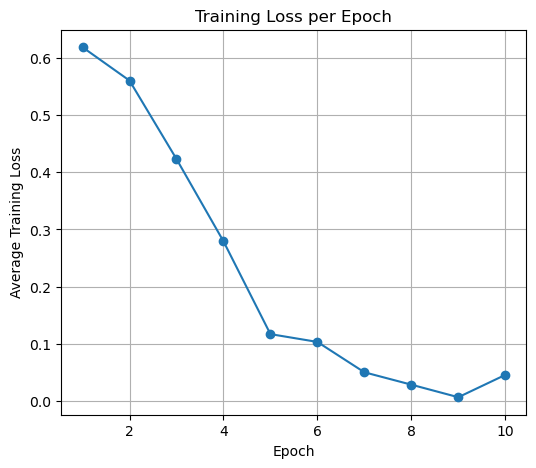

In [17]:
plt.figure(figsize=(6, 5))
plt.plot(range(1, len(epoch_losses)+1), epoch_losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')
plt.title('Training Loss per Epoch')
plt.grid(True)
plt.show()

In [18]:
#Model Evaluation
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch["labels"].cpu().numpy())
print(classification_report(all_labels, all_preds, target_names=["No AE", "Adverse Event"]))


               precision    recall  f1-score   support

        No AE       0.70      0.67      0.68        84
Adverse Event       0.77      0.79      0.78       116

     accuracy                           0.74       200
    macro avg       0.73      0.73      0.73       200
 weighted avg       0.74      0.74      0.74       200



### 7. Drug Readmission

In [35]:
#Define oncology drug reference list
oncology_drugs = [
    'CHEMO', 'CHEMOTHERAPY', 'ANTINEOPLASTIC', 'CYTOTOXIC',
    'CISPLATIN', 'CARBOPLATIN', 'OXALIPLATIN', 'DOXORUBICIN', 'EPIRUBICIN', 'IDARUBICIN',
    'BEVACIZUMAB', 'TRASTUZUMAB', 'PERTUZUMAB', 'RITUXIMAB', 'OFATUMUMAB', 'OBINUTUZUMAB',
    'PACLITAXEL', 'DOCETAXEL', 'NAB-PACLITAXEL', 
    'GEMCITABINE', 'TEMOZOLOMIDE', 'PEMETREXED', 'VINCRISTINE', 'VINBLASTINE', 'VINORELBINE',
    'ETOPOSIDE', 'TOPOTECAN', 'IRINOTECAN',
    'CYCLOPHOSPHAMIDE', 'IFOSFAMIDE', 'MELPHALAN', 'BUSULFAN',
    'METHOTREXATE', '5-FLUOROURACIL', '5FU', 'CAPECITABINE',
    'BLEOMYCIN', 'DAUNORUBICIN', 'CYTARABINE', 'AZACITIDINE', 'DECITABINE',
    'BORTEZOMIB', 'CARFILZOMIB',
    'IMATINIB', 'DASATINIB', 'NILOTINIB', 'PONATINIB',
    'NIVOLUMAB', 'PEMBROLIZUMAB', 'ATEZOLIZUMAB', 'DURVALUMAB', 'AVELUMAB',
    'IPILIMUMAB', 'TISLELIZUMAB',
    'SORAFENIB', 'LENVATINIB', 'REGORAFENIB', 'CABOZANTINIB',
    'EVEROLIMUS', 'TEMSIROLIMUS',
    'TAMOXIFEN', 'LETROZOLE', 'ANASTROZOLE', 'EXEMESTANE',
    'FULVESTRANT',
    'ENZALUTAMIDE', 'ABIRATERONE',
    'OLAPARIB', 'RUCAPARIB', 'NIRAPARIB', 'TALAZOPARIB',
    'LAPATINIB', 'AFATINIB', 'ERLOTINIB', 'GEFITINIB',
    'CRIZOTINIB', 'CERITINIB', 'ALECTINIB',
    'VENETOCLAX'
]

#SUBJECT_ID is indexed and de-duplicated incase if dup exists
features = features.reset_index().drop_duplicates(subset='SUBJECT_ID').set_index('SUBJECT_ID')

#Select only AE-labeled SUBJECT_IDs from sample_notes
ae_patients_sample = sample_notes[sample_notes['LABEL'] == 1]['SUBJECT_ID'].unique()

#Filter prescriptions for oncology patients
rx_oncology = prescriptions[prescriptions['SUBJECT_ID'].isin(oncology_patient_ids)].copy()

#Merge in patient cluster data from features
rx_oncology = rx_oncology.merge(
    features[['CLUSTER_HDBSCAN']],
    left_on='SUBJECT_ID',
    right_index=True,
    how='inner'
)

#Mark patients with known AE labels
rx_oncology['AE_FLAG'] = rx_oncology['SUBJECT_ID'].isin(ae_patients_sample)

#For each cluster, get top 3 most common drugs among non-AE patients
safe_drugs = (
    rx_oncology[rx_oncology['AE_FLAG'] == False]
    .groupby(['CLUSTER_HDBSCAN', 'DRUG'])
    .size()
    .reset_index(name='count')
    .sort_values(['CLUSTER_HDBSCAN', 'count'], ascending=[True, False])
)

#Define function to recommend safe cluster drugs
def recommend_drugs_for_patient(subj_id):
    if subj_id not in features.index:
        return ["Patient not in features"]
    cluster_val = features.loc[subj_id, 'CLUSTER_HDBSCAN']
    safe = safe_drugs[safe_drugs['CLUSTER_HDBSCAN'] == cluster_val]
    return safe['DRUG'].head(30).tolist() if not safe.empty else ["No safe drugs found"]



#Apply recommendations
sample_notes = sample_notes.reset_index(drop=True)
sample_notes['RECOMMENDED_DRUGS'] = sample_notes['SUBJECT_ID'].apply(recommend_drugs_for_patient)

#Create CURRENT_DRUGS list (pipe-delimited) per patient
all_drugs_grouped = (
    prescriptions.dropna(subset=['DRUG'])  # ensure valid values
    .groupby('SUBJECT_ID')['DRUG']
    .apply(lambda x: ' | '.join(sorted(set(x))))
    .reset_index()
    .rename(columns={'DRUG': 'CURRENT_DRUGS'})
)
if 'CURRENT_DRUGS' in sample_notes.columns:
    sample_notes = sample_notes.drop(columns=['CURRENT_DRUGS'])

#Merge current drug list into sample_notes
sample_notes = sample_notes.merge(all_drugs_grouped, on='SUBJECT_ID', how='left')

# Filter RECOMMENDED_DRUGS to only oncology drugs
def filter_oncology(drugs):
    if isinstance(drugs, list):
        return [d for d in drugs if any(drug in d.upper() for drug in oncology_drugs)]
    else:
        return []


# sample_notes['RECOMMENDED_DRUGS'] = sample_notes['RECOMMENDED_DRUGS'].apply(filter_oncology) # need to fix this part to slect the oncology drugs
sample_notes['RECOMMENDED_DRUGS'] = sample_notes['RECOMMENDED_DRUGS']
final_step5_output = sample_notes[['SUBJECT_ID', 'LABEL', 'CURRENT_DRUGS', 'RECOMMENDED_DRUGS']]
#print(final_step5_output.head(100))
final_step5_output

,SUBJECT_ID,LABEL,CURRENT_DRUGS,RECOMMENDED_DRUGS
0,11,1,*NF* Temozolomide | Acetaminophen | Dexamethas...,"[Dexamethasone, 0.9% Sodium Chloride, Potassiu..."
1,12,1,Albuterol Neb Soln | Atenolol | Calcium Glucon...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
2,21,1,Acetaminophen | Acetylcysteine 20% | Amino Aci...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
3,23,0,0.9% Sodium Chloride | 5% Dextrose | Acetamino...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
4,31,0,Acetaminophen | Acyclovir | Albuterol-Ipratrop...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
...,...,...,...,...
995,8485,1,1/2 NS | Albuterol 0.083% Neb Soln | Ampicilli...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
996,8494,1,Acetaminophen | Albuterol 0.083% Neb Soln | Al...,"[Potassium Chloride, 0.9% Sodium Chloride, NS,..."
997,8499,0,1/2 NS | Acetaminophen | Acetylcysteine 20% | ...,"[Insulin, D5W, NS, HydrALAzine, Potassium Chlo..."
998,8502,0,Acetaminophen | Acetaminophen (Liquid) | Albut...,"[Potassium Chloride, Furosemide, NS, 0.9% Sodi..."
